# Credit Card Transaction Data Simulator

## Imports

In [1]:
import os

import numpy as np
import pandas as pd

import datetime
import time

import random

# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor':'0.9'})

from pandarallel import pandarallel
pandarallel.initialize()



INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Customer profiles generation

In [2]:
def generate_customer_profiles_table(n_customers, random_state=0):
    np.random.seed(random_state)
    
    customer_id_properties = []
    
    #Generate customer properties from random distributions
    for customer_id in range(n_customers):
        
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) #Arbitrary (but sensible) value
        std_amount = mean_amount/2
        
        mean_nb_tx_per_day = np.random.uniform(0,4)
        customer_id_properties.append([customer_id,
                                      x_customer_id,
                                      y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
    
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID', 'x_customer_id', 'y_customer_id', 'mean_amount',
                                                                           'std_amount','mean_nb_tx_per_day'])
    return customer_profiles_table

In [3]:
n_customers=5
customer_profiles_table = generate_customer_profiles_table(n_customers, random_state=0)
customer_profiles_table

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day
0,0,54.881350,71.518937,62.262521,31.131260,2.179533
1,1,42.365480,64.589411,46.570785,23.285393,3.567092
2,2,96.366276,38.344152,80.213879,40.106939,2.115580
3,3,56.804456,92.559664,11.748426,5.874213,0.348517
4,4,2.021840,83.261985,78.924891,39.462446,3.480049


## Terminal profiles generation

In [4]:
def generate_terminal_profiles_table(n_terminals, random_state=0):
    np.random.seed(random_state)
    
    terminal_id_properties =[]
    
    #Generate terminal properties from random distributions
    for terminal_id in range(n_terminals):
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        
        terminal_id_properties.append([terminal_id, x_terminal_id, y_terminal_id])
    
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID','x_terminal_id','y_terminal_id'])
    
    return terminal_profiles_table

In [5]:
n_terminals=5
terminal_profiles_table=generate_terminal_profiles_table(n_terminals, random_state=0)
terminal_profiles_table

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,54.881350,71.518937
1,1,60.276338,54.488318
2,2,42.365480,64.589411
3,3,43.758721,89.177300
4,4,96.366276,38.344152


## Association of Customer profiles to terminals

Customers can only perform transactions on terminals that are within a radius of r of their geographical locations

In [6]:
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    # Use numpy arrays in the following to speed up computations
    
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute squared root to compute distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])
                                          
    return available_terminals

In [7]:
# We first get the geographical locations of all terminals as a numpy array
x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)

# And get the list of terminals within radius of $50$ for the last customer
get_list_terminals_within_radius(customer_profiles_table.iloc[4], x_y_terminals=x_y_terminals, r=50)

[2, 3]

Text(0, 0.5, 'y_terminal_id')

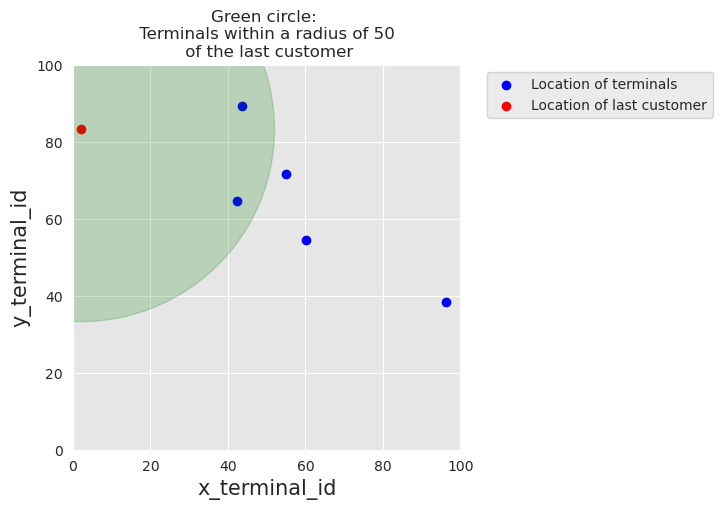

In [8]:
terminals_available_to_customer_fig, ax = plt.subplots(figsize=(5,5))

# Plot locations of terminals
ax.scatter(terminal_profiles_table.x_terminal_id.values,
           terminal_profiles_table.y_terminal_id.values,
           color='blue', label='Location of terminals')

# Plot location of the last customer
customer_id = 4
ax.scatter(customer_profiles_table.iloc[customer_id].x_customer_id,
          customer_profiles_table.iloc[customer_id].y_customer_id,
          color='red', label="Location of last customer")

ax.legend(loc='upper left', bbox_to_anchor=(1.05,1))

# Plot the region within the radius of 50 of the last customer
circ = plt.Circle((customer_profiles_table.iloc[customer_id].x_customer_id,
                 customer_profiles_table.iloc[customer_id].y_customer_id), radius=50, color='g', alpha=0.2)
ax.add_patch(circ)

fontsize=15

ax.set_title("Green circle: \n Terminals within a radius of 50 \n of the last customer")
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
    
ax.set_xlabel('x_terminal_id', fontsize=fontsize)
ax.set_ylabel('y_terminal_id', fontsize=fontsize)

In [9]:
customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=50), axis=1)
customer_profiles_table

## Generation of transactions

Takes as input a customer profile, a start date, and a number of days to which to generate transactions. It will return a table of transactions without a label

In [11]:
def generate_transactions_table(customer_profile, start_date = "2018-04-01", nb_days=10):
    customer_transactions = []
    
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # If nb_tx is positive, let us generate transactions
        if nb_tx > 0:
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. 
                # This choice aims at simulating the fact that most transactions occur during the day
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # if amount is negative, draw from a uniform distribution
                    if amount < 0:
                        amount = np.random.uniform(0, customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                    
                    if len(customer_profile.available_terminals) > 0:
                        terminal_id = random.choice(customer_profile.available_terminals)
                        
                        customer_transactions.append([time_tx+day*86400, day, customer_profile.CUSTOMER_ID,
                                                     terminal_id, amount])
    
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions = customer_transactions[['TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions
    

Generate transactions for the first customer, for five days, starting at the date 2018-04-01

In [12]:
transaction_table_customer_0 = generate_transactions_table(customer_profiles_table.iloc[0],
                                                          start_date = "2018-04-01",
                                                          nb_days = 5)
transaction_table_customer_0

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,2018-04-01 07:19:05,0,3,123.59,26345,0
1,2018-04-01 19:02:02,0,3,46.51,68522,0
2,2018-04-01 18:00:16,0,0,77.34,64816,0
3,2018-04-02 15:13:02,0,2,32.35,141182,1
4,2018-04-02 14:05:38,0,3,63.30,137138,1
5,2018-04-02 15:46:51,0,3,13.59,143211,1
6,2018-04-02 08:51:06,0,2,54.72,118266,1
7,2018-04-02 20:24:47,0,3,51.89,159887,1
8,2018-04-03 12:15:47,0,2,117.91,216947,2
9,2018-04-03 08:50:09,0,1,67.72,204609,2


Generate transactions for all customers

In [13]:
transactions_df = customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x: generate_transactions_table(x.iloc[0], nb_days=5)).reset_index(drop=True)
transactions_df

,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,2018-04-01 07:19:05,0,3,123.59,26345,0
1,2018-04-01 19:02:02,0,3,46.51,68522,0
2,2018-04-01 18:00:16,0,0,77.34,64816,0
3,2018-04-02 15:13:02,0,2,32.35,141182,1
4,2018-04-02 14:05:38,0,3,63.30,137138,1
...,...,...,...,...,...,...
60,2018-04-05 07:41:19,4,2,111.38,373279,4
61,2018-04-05 06:59:59,4,3,80.36,370799,4
62,2018-04-05 17:23:34,4,2,53.25,408214,4
63,2018-04-05 12:51:38,4,2,36.44,391898,4


In [14]:
def generate_dataset(n_customers = 10000, n_terminals = 1000000, nb_days=90, start_date="2018-04-01", r=5):
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 1)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    #customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    # With Pandarallel
    customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    #transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    # With Pandarallel
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)

In [15]:
(customer_profiles_table, terminal_profiles_table, transactions_df)=\
    generate_dataset(n_customers = 5000, 
                     n_terminals = 10000, 
                     nb_days=183, 
                     start_date="2018-04-01", 
                     r=5)

Time to generate customer profiles table: 0.025s
Time to generate terminal profiles table: 0.06s
Time to associate terminals to customers: 0.34s
Time to generate transactions: 9.8s


In [16]:
transactions_df.shape

(1754155, 7)

Plot the distribution of transaction amounts and transaction times

[Text(0.5, 0, 'Time (days)'), Text(0, 0.5, 'Number of transactions')]

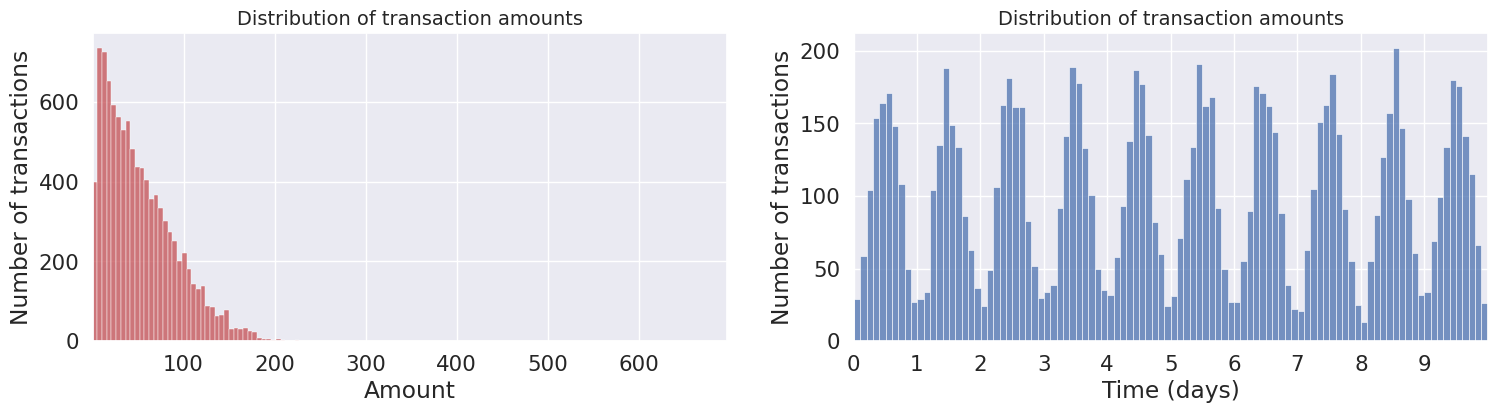

In [32]:
distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values 
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values

#Deprecated
#sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
sns.histplot(amount_val, ax=ax[0], color='r', kde=False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel="Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
#Deprecated
#sns.distplot(time_val/86400, ax=ax[1], color='b', bins=100, hist=True, kde=False)

sns.histplot(time_val/86400, ax=ax[1], color='b', bins=100, kde=False)
ax[1].set_title('Distribution of transaction amounts',fontsize=14)
ax[1].set_xlim([min(time_val/86400),max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")


The distribution of transaction amounts has most of its mass for small amounts. The distribution of transaction times follows a gaussian distribution on a daily basis, centred around noon. These two distributions are in accordance with the simulation parameters used in the previous sections


## Fraud scenarios generation

In [18]:
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df):
    # By default all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
    
    #Scenario 1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD']=1
    transactions_df.loc[transactions_df.TX_AMOUNT>220, 'TX_FRAUD_SCENARIO']=1
    nb_frauds_scenario_1=transactions_df.TX_FRAUD.sum()
    print("Number of frauds from scenario 1:" +str(nb_frauds_scenario_1))
    
    #Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=2, random_state=day)
        compromised_transactions = transactions_df[(transactions_df.TX_TIME_DAYS>=day) &
                                                  (transactions_df.TX_TIME_DAYS<day+28) &
                                                  (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
        
        transactions_df.loc[compromised_transactions.index, 'TX_FRAUD'] = 1
        transactions_df.loc[compromised_transactions.index, 'TX_FRAUD_SCENARIO'] = 2
        
    nb_frauds_scenario_2 = transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: " +str(nb_frauds_scenario_2))
    
    #Scenario3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=3, random_state=day).values
        
        compromised_transactions=transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+14) & 
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        nb_compromised_transactions=len(compromised_transactions)
        
        
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3
                                                   
    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    return transactions_df                  
        

In [19]:
%time transactions_df = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df)

Number of frauds from scenario 1:978
Number of frauds from scenario 2: 9099
Number of frauds from scenario 3: 4604
CPU times: user 54 s, sys: 7.04 ms, total: 54 s
Wall time: 54 s


In [20]:
transactions_df.TX_FRAUD.mean()

0.008369271814634397

In [21]:
transactions_df.TX_FRAUD.sum()

14681

In [22]:
transactions_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


In [23]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==1].shape

(973, 9)

In [24]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==2].shape

(9077, 9)

In [25]:
transactions_df[transactions_df.TX_FRAUD_SCENARIO==3].shape

(4631, 9)

In [26]:
def get_stats(transactions_df):
    #Number of transactions per day
    nb_tx_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['CUSTOMER_ID'].count()
    #Number of fraudulent transactions per day
    nb_fraud_per_day=transactions_df.groupby(['TX_TIME_DAYS'])['TX_FRAUD'].sum()
    #Number of fraudulent cards per day
    nb_fraudcard_per_day=transactions_df[transactions_df['TX_FRAUD']>0].groupby(['TX_TIME_DAYS']).CUSTOMER_ID.nunique()
    
    return (nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)

(nb_tx_per_day,nb_fraud_per_day,nb_fraudcard_per_day)=get_stats(transactions_df)

n_days=len(nb_tx_per_day)
tx_stats=pd.DataFrame({"value":pd.concat([nb_tx_per_day/50,nb_fraud_per_day,nb_fraudcard_per_day])})
tx_stats['stat_type']=["nb_tx_per_day"]*n_days+["nb_fraud_per_day"]*n_days+["nb_fraudcard_per_day"]*n_days
tx_stats=tx_stats.reset_index()

In [27]:
%%capture

sns.set(style='darkgrid')
sns.set(font_scale=1.4)

fraud_and_transactions_stats_fig = plt.gcf()

fraud_and_transactions_stats_fig.set_size_inches(15, 8)

sns_plot = sns.lineplot(x="TX_TIME_DAYS", y="value", data=tx_stats, hue="stat_type", hue_order=["nb_tx_per_day","nb_fraud_per_day","nb_fraudcard_per_day"], legend=False)

sns_plot.set_title('Total transactions, and number of fraudulent transactions \n and number of compromised cards per day', fontsize=20)
sns_plot.set(xlabel = "Number of days since beginning of data generation", ylabel="Number")

sns_plot.set_ylim([0,300])

labels_legend = ["# transactions per day (/50)", "# fraudulent txs per day", "# fraudulent cards per day"]

sns_plot.legend(loc='upper left', labels=labels_legend,bbox_to_anchor=(1.05, 1), fontsize=15)

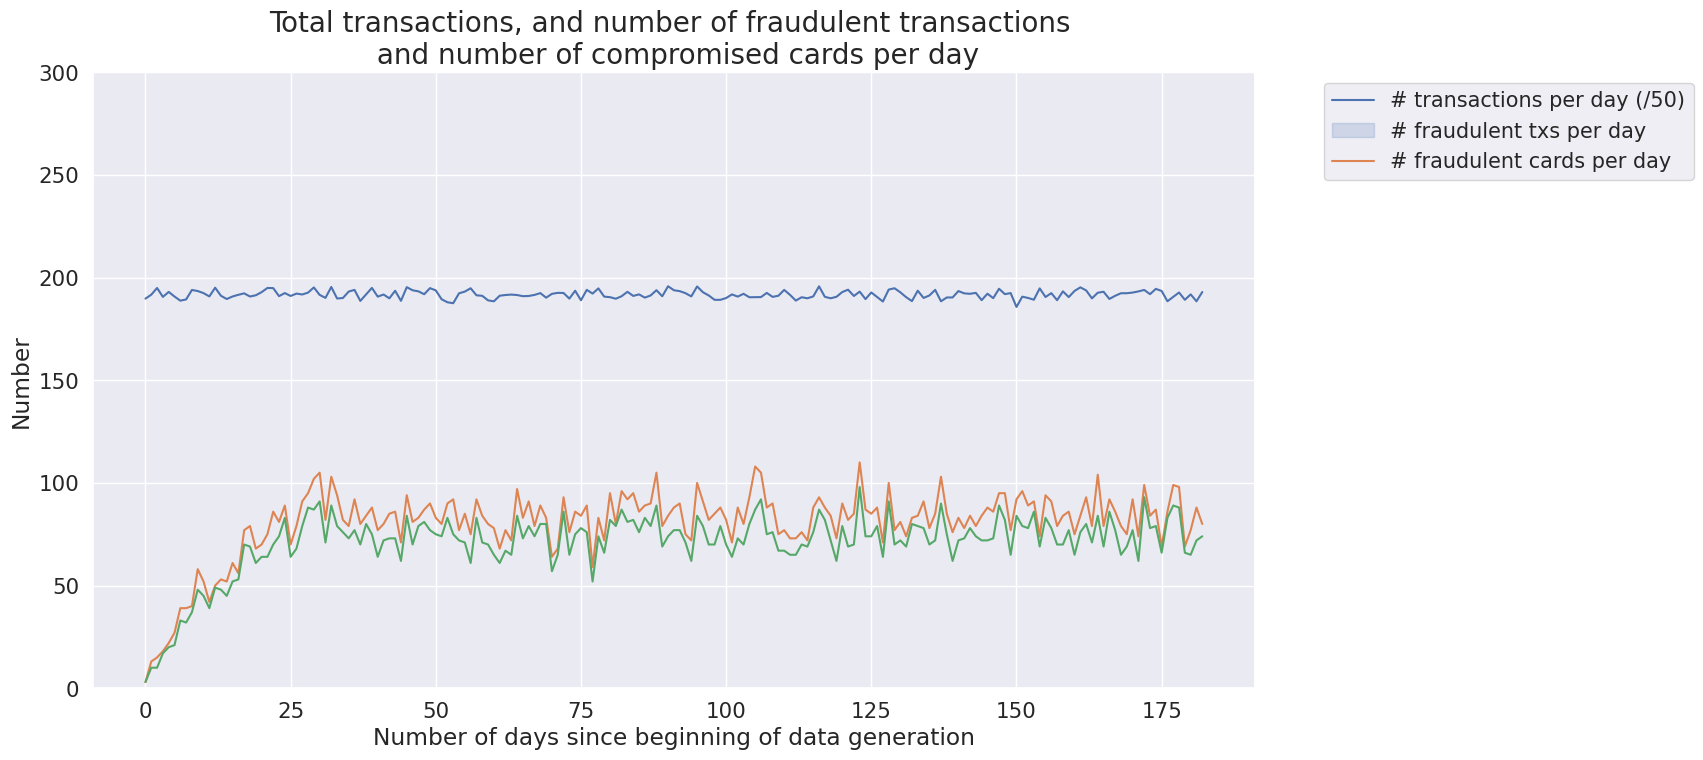

In [28]:
fraud_and_transactions_stats_fig

## Saving the dataset

In [29]:
DIR_OUTPUT = "./simulated-data-raw/"

if not os.path.exists(DIR_OUTPUT):
    os.makedirs(DIR_OUTPUT)

start_date = datetime.datetime.strptime("2018-04-01", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT+filename_output, protocol=4)

## References

https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html